In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [6]:
#load data
import glob

#train_images = []
#test_images = []
train_images = glob.glob('./input/fingers/train/*.png')
test_images = glob.glob('./input/fingers/test/*.png')
myfingers = glob.glob('./input/myfinger/*.jpg')

#print(len(myfingers))
print(len(train_images), len(test_images), len(myfingers))

18000 3600 24000


In [7]:
# 기존 data에 myfinger 넣어주기 (뒤에 이 데이터들이 쏠려있겠지만, 데이터로드시 shuffle해주니 괜찮을 것이라고 생각.)
train_images.extend(myfingers[:20000])
test_images.extend(myfingers[20000:])
print(len(train_images), len(test_images))

38000 7600


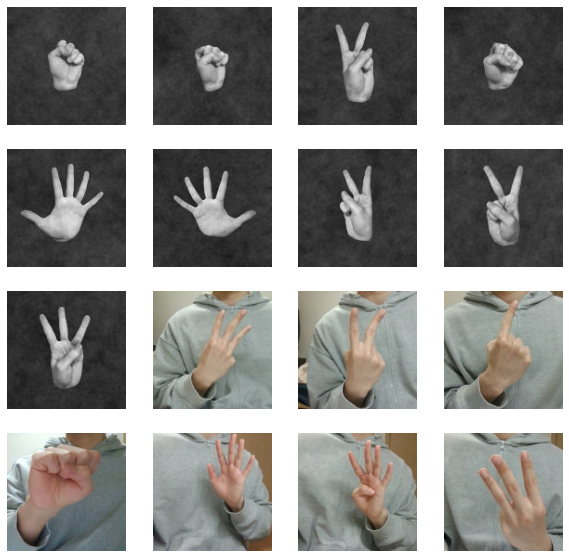

In [8]:
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    if i <= 8:
        plt.imshow(cv2.imread(train_images[i]))
    else :
        plt.imshow(plt.imread(train_images[25500 - i]))
    plt.axis("off")

In [9]:
img = cv2.imread(train_images[20000])
height, width, channels = img.shape
print(height,width,channels)

224 224 3


In [18]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision.io import read_image

device = torch.device('cpu')  # 'cuda' if torch.cuda.is_available else 'cpu'
print(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
    transforms.ColorJitter()
])

cpu


In [19]:
train_labels = [int(x[-6:-5]) for x in train_images]

In [20]:
a = np.array(train_labels) 
np.unique(a) # 라벨링이 잘되어있나 확인

array([0, 1, 2, 3, 4, 5])

In [21]:
#커스텀 데이터셋 설정
#dataset and dataloader for train
class train_dataset(Dataset) :
    def __init__(self, image_list, image_labels, transform, device) :
        self.image_list = image_list
        self.image_labels = image_labels
        self.transform = transform
        self.device = device
    
    def __len__(self) :
        return len(self.image_list)
    
    def __getitem__(self, index) :
        x = cv2.imread(self.image_list[index])
        x = self.transform(x).to(self.device)
        
        y = self.image_labels[index]
        y = torch.LongTensor([y,]).to(self.device) # LongTensor : to intege tensor
        
        return x, y
        
class test_dataset(Dataset) :
    def __init__(self, image_list, transform, device) :
        self.image_list = image_list
        self.transform = transform
        self.image_labels = [int(x[-6:-5]) for x in self.image_list]
        self.device = device
    
    def __len__(self) :
        return len(self.image_list)
    
    def __getitem__(self, index) :
        x = cv2.imread(self.image_list[index])
        x = self.transform(x).to(self.device)
        
        y = self.image_labels[index]
        y = torch.LongTensor([y,]).to(self.device) # LongTensor : to intege tensor
        
        return x, y


In [22]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size = 0.15, 
                                                                  stratify = train_labels, random_state = 42)
len(train_images), len(val_images), len(train_labels), len(val_labels),

(27455, 4845, 27455, 4845)

In [23]:
#load train_images
train_data = train_dataset(train_images, train_labels, transform, device)
train_data = DataLoader(train_data, batch_size = 32, shuffle = True) # dataSampler -> shuffle로 대체 가능?

#load val_images
val_data = train_dataset(val_images, val_labels, transform, device)
val_data = DataLoader(val_data, batch_size = 32, shuffle = True)

#load test_images
test_data = test_dataset(test_images, transform, device)
test_data = DataLoader(test_data, batch_size = 32, shuffle = True)

In [24]:
train_iterator = iter(train_data)

In [25]:
a1 = next(train_iterator)

In [26]:
a1[0].shape

torch.Size([32, 3, 256, 256])

In [27]:
!pip install torchsummaryX

You should consider upgrading via the 'C:\Users\sangm\anaconda3\python.exe -m pip install --upgrade pip' command.


In [28]:
import torch.nn as nn
from torch.optim import Adam
from torchvision.models import resnet34, mobilenet_v2
from torchsummaryX import summary

#### MobilNet ####
class mobile(nn.Module) :
    def __init__(self, output) :
        super().__init__()
        self.model = mobilenet_v2(pretrained=True) #use Densenet
        self.model.fc = torch.nn.Linear(1280, output) #change the last FC layer
        
    def forward(self, x) :
        output = self.model(x)
        return output

classes = 6
model = mobile(classes).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

summary(model, torch.rand((1, 3, 224, 224)).float().to(device))

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\sangm/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

                                                 Kernel Shape  \
Layer                                                           
0_model.features.0.Conv2d_0                     [3, 32, 3, 3]   
1_model.features.0.BatchNorm2d_1                         [32]   
2_model.features.0.ReLU6_2                                  -   
3_model.features.1.conv.0.Conv2d_0              [1, 32, 3, 3]   
4_model.features.1.conv.0.BatchNorm2d_1                  [32]   
5_model.features.1.conv.0.ReLU6_2                           -   
6_model.features.1.conv.Conv2d_1               [32, 16, 1, 1]   
7_model.features.1.conv.BatchNorm2d_2                    [16]   
8_model.features.2.conv.0.Conv2d_0             [16, 96, 1, 1]   
9_model.features.2.conv.0.BatchNorm2d_1                  [96]   
10_model.features.2.conv.0.ReLU6_2                          -   
11_model.features.2.conv.1.Conv2d_0             [1, 96, 3, 3]   
12_model.features.2.conv.1.BatchNorm2d_1                 [96]   
13_model.features.2.conv.

C:\Users\sangm\anaconda3\lib\site-packages\torchsummaryX\torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_model.features.0.Conv2d_0,"[3, 32, 3, 3]","[1, 32, 112, 112]",864.0,10838016.0
1_model.features.0.BatchNorm2d_1,[32],"[1, 32, 112, 112]",64.0,32.0
2_model.features.0.ReLU6_2,-,"[1, 32, 112, 112]",NaN,NaN
3_model.features.1.conv.0.Conv2d_0,"[1, 32, 3, 3]","[1, 32, 112, 112]",288.0,3612672.0
4_model.features.1.conv.0.BatchNorm2d_1,[32],"[1, 32, 112, 112]",64.0,32.0
...,...,...,...,...
136_model.features.18.Conv2d_0,"[320, 1280, 1, 1]","[1, 1280, 7, 7]",409600.0,20070400.0
137_model.features.18.BatchNorm2d_1,[1280],"[1, 1280, 7, 7]",2560.0,1280.0
138_model.features.18.ReLU6_2,-,"[1, 1280, 7, 7]",NaN,NaN


In [29]:
import torch.nn as nn
from torch.optim import Adam
from torchsummaryX import summary
from torchvision import models

#### ShuffleNet ####
class suffle(nn.Module) :
    def __init__(self, output) :
        super().__init__()
        self.model = models.shufflenet_v2_x1_0(pretrained=True)
        self.model.fc = torch.nn.Linear(1024, output) #change the last FC layer
        
    def forward(self, x) :
        output = self.model(x)
        return output

classes = 6
model = suffle(classes).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

summary(model, torch.rand((1, 3, 256, 256)).float().to(device))

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to C:\Users\sangm/.cache\torch\hub\checkpoints\shufflenetv2_x1-5666bf0f80.pth


  0%|          | 0.00/8.79M [00:00<?, ?B/s]

                                               Kernel Shape  \
Layer                                                         
0_model.conv1.Conv2d_0                        [3, 24, 3, 3]   
1_model.conv1.BatchNorm2d_1                            [24]   
2_model.conv1.ReLU_2                                      -   
3_model.MaxPool2d_maxpool                                 -   
4_model.stage2.0.branch1.Conv2d_0             [1, 24, 3, 3]   
5_model.stage2.0.branch1.BatchNorm2d_1                 [24]   
6_model.stage2.0.branch1.Conv2d_2            [24, 58, 1, 1]   
7_model.stage2.0.branch1.BatchNorm2d_3                 [58]   
8_model.stage2.0.branch1.ReLU_4                           -   
9_model.stage2.0.branch2.Conv2d_0            [24, 58, 1, 1]   
10_model.stage2.0.branch2.BatchNorm2d_1                [58]   
11_model.stage2.0.branch2.ReLU_2                          -   
12_model.stage2.0.branch2.Conv2d_3            [1, 58, 3, 3]   
13_model.stage2.0.branch2.BatchNorm2d_4                

C:\Users\sangm\anaconda3\lib\site-packages\torchsummaryX\torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_model.conv1.Conv2d_0,"[3, 24, 3, 3]","[1, 24, 128, 128]",648.0,10616832.0
1_model.conv1.BatchNorm2d_1,[24],"[1, 24, 128, 128]",48.0,24.0
2_model.conv1.ReLU_2,-,"[1, 24, 128, 128]",NaN,NaN
3_model.MaxPool2d_maxpool,-,"[1, 24, 64, 64]",NaN,NaN
4_model.stage2.0.branch1.Conv2d_0,"[1, 24, 3, 3]","[1, 24, 32, 32]",216.0,221184.0
...,...,...,...,...
146_model.stage4.3.branch2.ReLU_7,-,"[1, 232, 8, 8]",NaN,NaN
147_model.conv5.Conv2d_0,"[464, 1024, 1, 1]","[1, 1024, 8, 8]",475136.0,30408704.0
148_model.conv5.BatchNorm2d_1,[1024],"[1, 1024, 8, 8]",2048.0,1024.0


In [30]:
from tqdm.notebook import tqdm

n_epoch = 5
torch.cuda.empty_cache() # ??

## train
model = model.train()

for epoch in range(n_epoch) :
    train_loss = 0
    train_acc = 0
    for x, y in tqdm(train_data) :
        y = y.reshape(-1)
        
        with torch.set_grad_enabled(True):
        predict = model(x)
        loss = criterion(predict, y)
        
        train_loss += loss / len(train_data)
        correct_prediction = torch.argmax(predict, 1) == y # predict값의 row에서 가장 큰 값 == y면 true?
        correct_prediction += correct_prediction.sum()
        train_acc += correct_prediction
        
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
    train_acc = train_acc / (32 * len(train_data))
    print('Epoch : {}/{},   train_loss : {:.5f},    train_acc : {:.5f}'.format(epoch+1, n_epoch, train_loss, train_acc))
## validation
    val_acc = 0
    val_loss = 0
    with torch.no_grad():
      model.eval()
      for x, y in tqdm(val_data) :
        y = y.reshape(-1)
        
        predict = model(x)
        loss = criterion(predict, y)
        
        val_loss += loss / len(val_data)
        correct_prediction = torch.argmax(predict, 1) == y # predict값의 row에서 가장 큰 값 == y면 true?
        correct_prediction = correct_prediction.sum()
        val_acc += correct_prediction
        
    val_acc = val_acc / (32 * len(val_data))
    print('Epoch : {}/{},   val_loss : {:.5f},    val_acc : {:.5f}'.format(epoch+1, n_epoch, val_loss, val_acc))

    if val_acc > 0.98 : break

  0%|          | 0/858 [00:00<?, ?it/s]

Epoch : 1/5,   train_loss : 0.09212,    train_acc : 0.97968


  0%|          | 0/152 [00:00<?, ?it/s]

Epoch : 1/5,   val_loss : 0.00262,    val_acc : 0.99589


In [32]:
import random
import matplotlib.pyplot as plt
import numpy as np
import time

start = time.time()
with torch.no_grad() :
    test_loss = 0
    test_acc = 0
    for i, (x, y) in enumerate(test_data) :
        y = y.reshape(-1)
        
        predict = model(x)
        loss = criterion(predict, y)

        test_loss += loss / len(test_data)
        correct_prediction = torch.argmax(predict, 1) == y # [True, Flase, True ...]
        correct_prediction = correct_prediction.sum()
        test_acc += correct_prediction
        
    test_acc = test_acc.item() / (32 * len(test_data))
    
    print("time :", time.time() - start)
    print('loss : {:.5f},    acc : {:.5f}'.format(test_loss, test_acc))


time : 280.54281783103943
loss : 0.01517,    acc : 0.99357


In [33]:
torch.save(model, 'ShuffleNet_total_model2.pt') # 전체 모델 저장
torch.save(model.state_dict(), 'ShuffleNet_model2.pt') # 가중치 저장

In [34]:
#### 새로운 데이터 test ####
transform_my = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Resize((256, 256)),
    #transforms.Grayscale(num_output_channels=1)
])

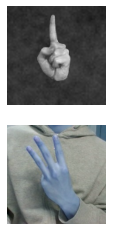

In [73]:
import PIL.Image as pilimg
import matplotlib.pyplot as plt

image_kaggle = cv2.imread('./input/fingers/test/00de9808-f8e3-425f-a8b8-204a69256df7_1L.png')
image_self = cv2.imread('./input/myfinger/12-3R.jpg') # 새로운 손 사진 업로드 후 사용했음.
# print(image)
fig, axs = plt.subplots(2, 1)
axs[0].imshow(image_kaggle)
axs[0].axis('off')
axs[1].imshow(image_self)
axs[1].axis('off')
plt.show()

In [74]:
image_self = transform_my(image_self).to(device)
image_kaggle = transform_my(image_kaggle).to(device)

In [75]:
image_self = image_self.unsqueeze(0)
image_kaggle = image_kaggle.unsqueeze(0)
print(image_self.shape)
print(image_kaggle.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


In [76]:
start = time.time()
pred_kaggle = model(image_kaggle)
print(f"{(time.time() - start)//60:.0f}m {(time.time() - start) % 60} s")

start = time.time()
pred_self = model(image_self)
print(f"{(time.time() - start)//60:.0f}m {(time.time() - start) % 60} s")

torch.set_printoptions(sci_mode=False) # e+2 이런식 말구 소수로 표현

print(pred_kaggle)
print(pred_self)

0m 0.0368196964263916 s
0m 0.028933048248291016 s
tensor([[-3.5220,  6.1159, -1.4138, -4.9861, -5.0142, -5.3101]],
       grad_fn=<AddmmBackward0>)
tensor([[-4.1475, -5.0562, -3.0868,  5.3467, -1.4798, -4.5249]],
       grad_fn=<AddmmBackward0>)


In [77]:
print(torch.argmax(pred_kaggle, 1))
print(torch.argmax(pred_self, 1))

tensor([1])
tensor([3])
